## Assignment: 12.1 - Term Project
## Name: Tae-Hyun Sakong
## Course: DSC 530-T303-2243-1
## Date: 03/02/2024

---

# Analyzing Predictors for Used Car Sales in India

---

## Data:

### Used-Car Data: [https://www.kaggle.com/datasets/shubham1kumar/usedcar-data]

## Summary:

This dataset is was curated to represent the used-car market in India. For each transaction, various information was collected:

- Sales_ID: unique identifier for each transaction
- Name: name of the vehicle
- Year: year the vehicle
- Selling_price: selling price for the vehicle in Lakh
- KM_Driven: current  mileage on the vehicle in KM
- Region: region in which the vehicle is located
- State or Provide: state or province in which the vehicle is located
- City: city in which the vehicle is located
- Fuel: type of fuel the vehicle uses
- Seller_type: type of seller for the vehicle
- Transmission: type of transmission for the vehicle
- Owner: the number of previous owners of the vehicle
- Mileage: KM per liter for the vehicle
- Engine: engine displacement in cubic centimeters
- Max_Power: max vehicle power in pferdestarkes
- Seats: number of seats in vehicle
- Sold: indicator if vehicle was sold or not

### Research Question
----

What are good predictors of used-car sales? Specifically, how does the vehicle's year, KM_Driven, mileage, engine size, or max power predict whether or not a vehicle is sold?

#### Data Cleaning:

---

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, lognorm
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import data 
data = pd.read_csv('UserCarData.csv')

In [2]:
# Check for missing values in the relevant columns
missing_values = data[['year', 'km_driven', 'mileage', 'engine', 'max_power', 'sold']].isnull().sum()

# Encode the 'Sold' column as binary (0 and 1)
# Assuming 'Y' represents sold and anything else represents not sold
data['sold'] = data['sold'].apply(lambda x: 1 if x == 'Y' else 0)

# Check the encoding result
encoding_result = data['sold'].value_counts()

missing_values, encoding_result

(year         0
 km_driven    0
 mileage      0
 engine       0
 max_power    0
 sold         0
 dtype: int64,
 0    5906
 1    2000
 Name: sold, dtype: int64)

### EDA: 

---
Produce histograms for year, km_driven, mileage, engine, and max_power.

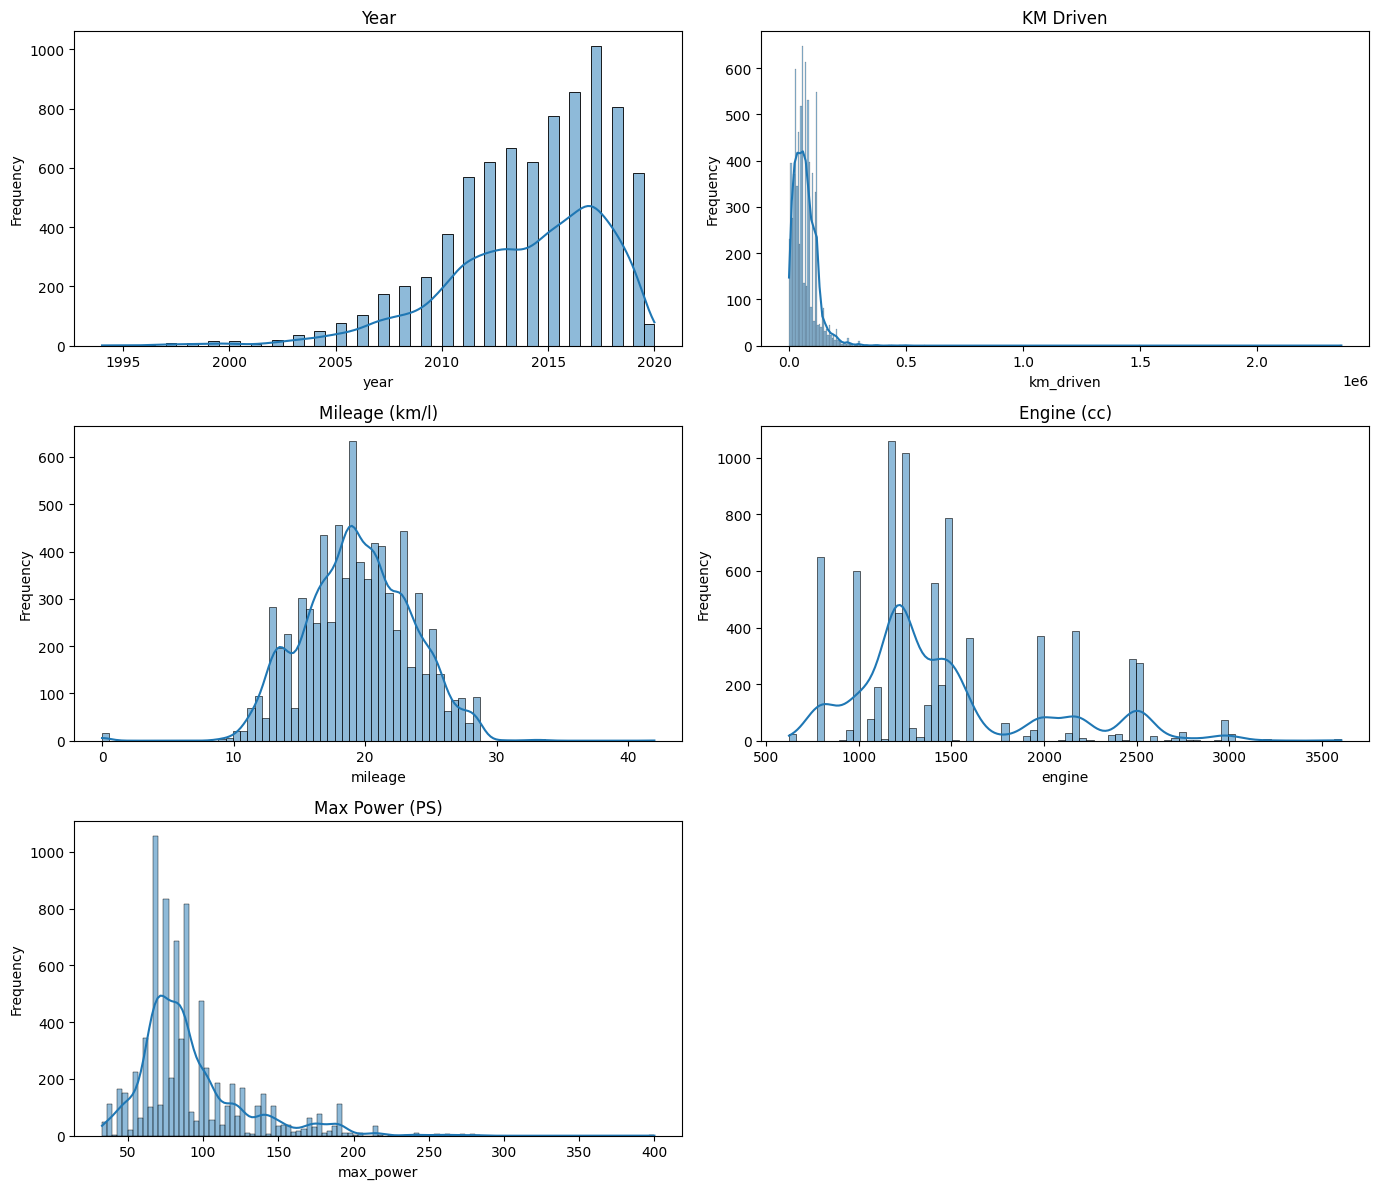

In [3]:
# Plot histograms for each independent variable: mileage, km_driven, mileage, engine, and max power
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

variables = ['year', 'km_driven', 'mileage', 'engine', 'max_power']
titles = ['Year', 'KM Driven', 'Mileage (km/l)', 'Engine (cc)', 'Max Power (PS)']

for ax, var, title in zip(axs.flat, variables, titles):
    sns.histplot(data[var], kde=True, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.delaxes(axs[2][1])  # Remove the empty subplot
plt.show()

#### EDA Summary:

- Year: The distribution shows that most cars in the dataset are relatively recent models, with a peak around 2015 to 2017. The distribution is left-skewed, indicating older models are less common.

- KM Driven: This variable has a right-skewed distribution, meaning most cars have lower kilometers driven, with a few cars having very high kilometers on the odometer.
- Mileage (km/l): The distribution of mileage is somewhat normal but with a slight right skew. There are cars with very low mileage that could be considered outliers.

- Engine (cc): The engine size distribution is also right-skewed, with most cars having smaller engines and a few cars having very large engines.

- Max Power (PS): Max power is right-skewed, indicating most cars have lower power, with a few high-powered cars.


#### Identify Outliers using the IQR Method
---

In [4]:
# Calculate IQR and identify outliers for each variable
outliers_summary = {}

for var in variables:
    Q1 = data[var].quantile(0.25)
    Q3 = data[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers_count = data[(data[var] < lower_bound) | (data[var] > upper_bound)].shape[0]
    
    outliers_summary[var] = {'Lower Bound': lower_bound, 'Upper Bound': upper_bound, 'Outliers Count': outliers_count}

pd.DataFrame(outliers_summary).T

,Lower Bound,Upper Bound,Outliers Count
year,2004.500,2024.500,165.0
km_driven,-55637.500,186062.500,194.0
mileage,8.470,30.630,24.0
engine,619.500,2159.500,1183.0
max_power,17.125,152.925,564.0


#### Handle Outliers Using Capping:

Given the large distribution of outliers across all variables: outliers were capped at the upper and lower bounds defined by the IQR method to reduce their impact while retaining all data points.

For each indepedent variable, (year, km_driven, mileage, engine, and max_power)outliers were capped at the lower and upper bounds calculated using the Interquartile Range (IQR) method. Meaning:

Values below the lower bound will be set to the lower bound.
Values above the upper bound will be set to the upper bound.


In [5]:
# Apply capping for each variable
for var in variables:
    Q1 = data[var].quantile(0.25)
    Q3 = data[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    data[var] = data[var].clip(lower=lower_bound, upper=upper_bound)

### Descriptive Statistics: after removing outliers
---


In [6]:
# Calculate descriptive statistics and mode for each variable
descriptive_stats = data[variables].describe()
mode_values = data[variables].mode().loc[0]
skewness = data[variables].skew()

# Append mode and skewness to the descriptive statistics
descriptive_stats = descriptive_stats.append(mode_values.rename('mode'))
descriptive_stats = descriptive_stats.append(skewness.rename('skewness'))

round(descriptive_stats,2)

C:\Users\tsako\AppData\Local\Temp\ipykernel_317060\3153319012.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  descriptive_stats = descriptive_stats.append(mode_values.rename('mode'))
C:\Users\tsako\AppData\Local\Temp\ipykernel_317060\3153319012.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  descriptive_stats = descriptive_stats.append(skewness.rename('skewness'))


,year,km_driven,mileage,engine,max_power
count,7906.00,7906.00,7906.00,7906.00,7906.00
mean,2014.04,67513.05,19.43,1415.51,89.21
std,3.67,43106.99,3.96,411.70,29.14
min,2004.50,1.00,8.47,624.00,32.80
25%,2012.00,35000.00,16.78,1197.00,68.05
50%,2015.00,60000.00,19.30,1248.00,82.00
75%,2017.00,95425.00,22.32,1582.00,102.00
max,2020.00,186062.50,30.63,2159.50,152.93
mode,2017.00,120000.00,18.90,2159.50,152.93
skewness,-0.67,0.71,0.01,0.61,0.77


### Descriptive Stats Summary:
---

#### Year: The year of the vehicles shows a slight preference for newer cars, with a lean towards models manufactured closer to 2017.
- Mean: 2014.04, indicating the average year of manufacture in the dataset is around 2014.
- Mode: 2017, which is the most common year of manufacture.
- Spread (Std. Deviation): 3.67, suggesting a relatively narrow range of manufacture years centered around the mean.
- Tails (Skewness): -0.67, indicating a slight left skew, meaning there are fewer older cars relative to newer ones.

#### KM Driven: shows a wide range of values with a right skew, indicating that while most cars have lower kilometers, there's a significant number with high usage.
- Mean: 67,513.05, showing the average kilometers driven.
- Mode: 120,000, which is somewhat higher than the mean, suggesting a popular entry point for km driven data.
- Spread (Std. Deviation): 43,106.99, indicating a wide variation in the kilometers driven by the cars in the dataset.
- Tails (Skewness): 0.71, showing a right skew, meaning there are a number of cars with very high km driven values.

#### Mileage: fairly consistent across the dataset, with a slight variation.
- Mean: 19.43 km/l, the average fuel efficiency.
- Mode: 18.9 km/l, the most common fuel efficiency reported.
- Spread (Std. Deviation): 3.96, indicating variability in the fuel efficiency of cars.
- Tails (Skewness): 0.01, showing a very symmetric distribution with no significant skewness.

#### Engine: show a right skew, indicating that while most cars in the dataset have moderate engine sizes, there are outliers with significantly higher values, even after capping.
- Mean: 1,415.51 cc, indicating the average engine displacement.
- Mode: 2,159.5 cc, suggesting that the largest engine size in the dataset is quite common after capping.
- Spread (Std. Deviation): 411.70, showing variability in engine sizes.
- Tails (Skewness): 0.61, indicating a moderate right skew, with a tendency toward smaller engines but with some larger ones as well.

#### Max Power: show a right skew, indicating that while most cars in the dataset have moderate power, there are outliers with significantly higher values, even after capping.
- Mean: 89.21 PS, the average maximum power of the vehicles.
- Mode: 152.925 PS, indicating the highest capped power value is a common occurrence in the dataset.
- Spread (Std. Deviation): 29.14, showing a range of vehicle power outputs.
- Tails (Skewness): 0.77, suggesting a right skew, with most cars having lower power, but a few have significantly higher power.

### PMF of Mileage for Cars that have sold vs have not sold

---

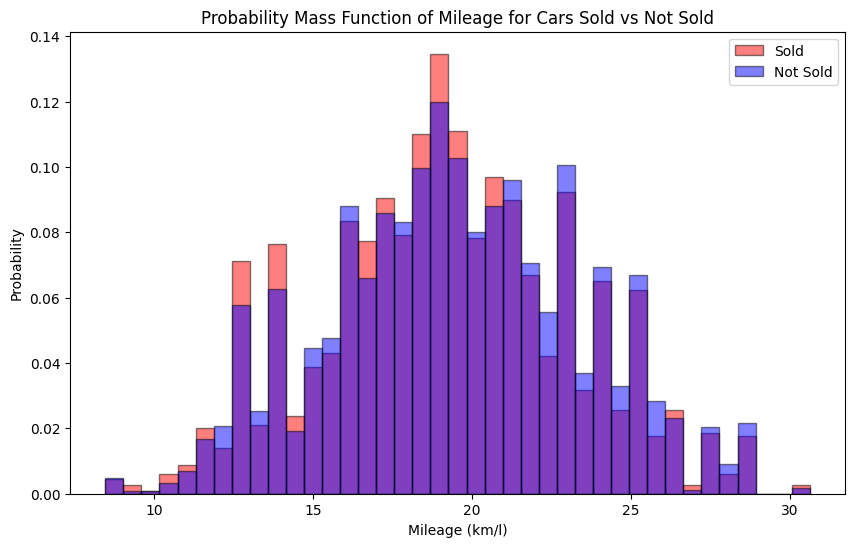

In [7]:
# Calculate PMF for mileage for cars that have sold vs have not sold
mileage_sold = data[data['sold'] == 1]['mileage']
mileage_not_sold = data[data['sold'] == 0]['mileage']

# Calculate the bins for the histogram
bins = np.linspace(data['mileage'].min(), data['mileage'].max(), 40)

# Normalize the histograms to get PMF
plt.figure(figsize=(10, 6))
plt.hist(mileage_sold, bins, alpha=0.5, label='Sold', density=True, edgecolor='black', color='red')
plt.hist(mileage_not_sold, bins, alpha=0.5, label='Not Sold', density=True, edgecolor='black', color='blue')

plt.xlabel('Mileage (km/l)')
plt.ylabel('Probability')
plt.title('Probability Mass Function of Mileage for Cars Sold vs Not Sold')
plt.legend(loc='upper right')
plt.show()

#### PMF Summary:

Both distributions for cars that have and have not sold cover a similar range of mileage values, indicating that mileage alone does not strongly differentiate between cars that are sold and those that are not.

There appears to be a slight overlap in the distributions, suggesting that while mileage may play a role in whether a car is sold, it is not the sole determining factor. Other variables and their interactions likely also influence the outcome.

### CDF of Vehicle 'Year'

---

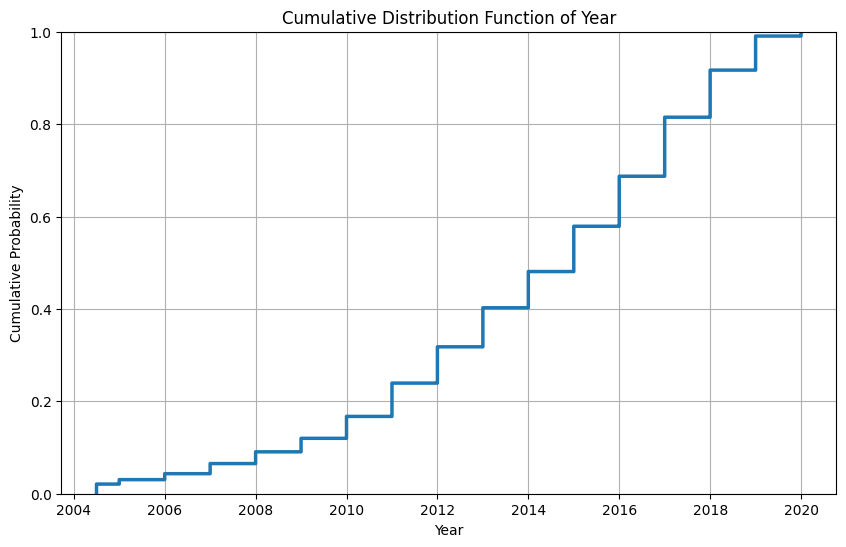

In [8]:
# Generate a CDF for the 'year'
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=data, x='year', linewidth=2.5)
plt.xlabel('Year')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function of Year')
plt.grid(True)
plt.show()

### CDF Summary of 'Year':

---

#### What the CDF Tells Us About the Variable 'Year'
The CDF shows the proportion of cars that were manufactured on or before a given year. It starts from the earliest year in the dataset and increases to 1 (or 100%) as it reaches the most recent year. The slope of the CDF indicates how densely packed the years of manufacture are within the dataset. A steeper slope indicates a higher concentration of vehicles manufactured within a shorter time span. 

From the plot, we can observe that the CDF is relatively steep in the more recent years, suggesting a significant proportion of the cars in the dataset were manufactured in the years closer to the maximum year in the dataset. This indicates that the dataset contains a large number of relatively newer cars.

#### How the CDF Addresses the Research Question
The research question focuses on identifying good predictors of used-car sales, specifically looking at how the vehicle's year, among other factors, predicts whether or not a vehicle is sold. 

The CDF of the 'year' helps in understanding the distribution of the car's years in the dataset, which can be linked to the likelihood of a car being sold in several ways:

- Market Trends: Newer cars may be more likely to be sold due to higher demand for recent models, which could be inferred from a concentration of sales in cars manufactured in recent years.
- Depreciation: The value of a car depreciates over time, so newer cars might retain more value, making them more attractive to buyers and possibly more likely to be sold.
- Condition: Newer cars may be in better condition, leading to a higher likelihood of sale.

By analyzing the cumulative distribution of car years, we can understand the age profile of cars within the dataset and then begin to infer how the age of a car might impact its sale potential. 

If the dataset shows a significant proportion of sales among newer cars, this could suggest that the year of manufacture is a strong predictor of whether a car is sold, aligning with the research question's focus on identifying predictors of used-car sales.

### Plot Analytical Distribution: Log-Normal Distribution of KM Driven

---

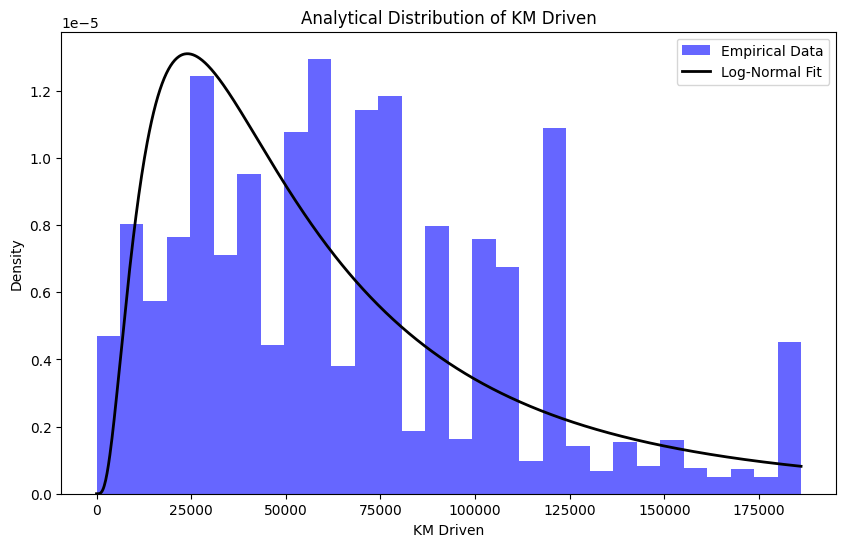

(0.8691866527872232, 0.0, 51095.376163652596)

In [9]:
# Estimate parameters for log-normal distribution
sigma, loc, scale = lognorm.fit(data['km_driven'], floc=0)

# Generate x values
x = np.linspace(data['km_driven'].min(), data['km_driven'].max(), 1000)

# Generate PDF for the log-normal distribution
pdf = lognorm.pdf(x, sigma, loc, scale)

# Plot empirical data histogram and the analytical PDF
plt.figure(figsize=(10, 6))
plt.hist(data['km_driven'], bins=30, density=True, alpha=0.6, color='blue', label='Empirical Data')
plt.plot(x, pdf, 'k', linewidth=2, label='Log-Normal Fit')
plt.xlabel('KM Driven')
plt.ylabel('Density')
plt.title('Analytical Distribution of KM Driven')
plt.legend()
plt.show()

sigma, loc, scale # Display the estimated parameters

##### Analytical Distribution of KM Driven
The plot above shows the empirical distribution of km_driven (in blue) alongside the fitted analytical distribution, which is modeled as a log-normal distribution (in black). The estimated parameters for the log-normal distribution are shape = 0.869, location = 0.0, and scale = 51,095.38.

### Summary of Analytical Distribution: Log-Normal Distribution of KM_Driven

---
> The research question seeks to understand good predictors of used-car sales, specifically examining how factors like the vehicle's year, km_driven, mileage, engine, and max power predict whether or not a vehicle is sold.

##### Modeling km_driven: 
> The analytical distribution (log-normal in this case) provides a mathematical model that describes how the kilometers driven are distributed across the dataset. This model can help in understanding the typical range and distribution shape of km_driven for cars in the dataset, which is important for predicting sales.

#### Insights for Prediction: 
> By fitting km_driven to an analytical distribution, we can infer that most cars have a moderate amount of kilometers driven, with fewer cars exhibiting extremely high mileage. This pattern suggests that cars with a typical range of kilometers driven might be more appealing to buyers, whereas cars with extremely high mileage might be less likely to be sold.


##### Analytical Modeling in Research: 
>The use of an analytical model for km_driven contributes to the research question by providing a clear, quantitative description of one of the predictor variables. It allows for the estimation of probabilities associated with different values of km_driven, which can be incorporated into predictive models for car sales.


### Scatter Plots: mileage vs km_driven, engine vs max power

---

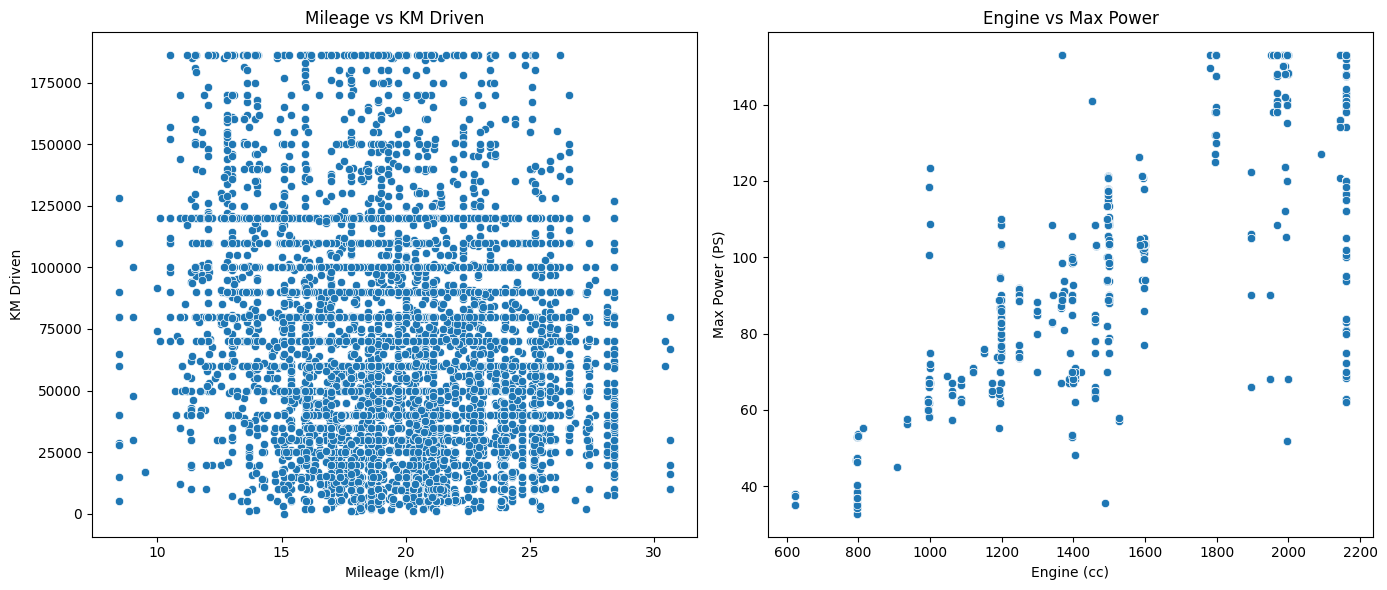

(-33332.313769645494,
 -0.19549681733902263,
 9286.007012499298,
 0.7739421357294897)

In [10]:
# Generate figure
plt.figure(figsize=(14, 6))

# Plot 1: Mileage vs KM Driven
plt.subplot(1, 2, 1)
sns.scatterplot(x='mileage', y='km_driven', data=data)
plt.title('Mileage vs KM Driven')
plt.xlabel('Mileage (km/l)')
plt.ylabel('KM Driven')

# Plot 2: Engine vs Max Power
plt.subplot(1, 2, 2)
sns.scatterplot(x='engine', y='max_power', data=data)
plt.title('Engine vs Max Power')
plt.xlabel('Engine (cc)')
plt.ylabel('Max Power (PS)')

plt.tight_layout()
plt.show()

# Calculate covariance, Pearson's correlation for both comparisons
covariance_mileage_km_driven = data[['mileage', 'km_driven']].cov().iloc[0,1]
correlation_mileage_km_driven = data[['mileage', 'km_driven']].corr().iloc[0,1]

covariance_engine_max_power = data[['engine', 'max_power']].cov().iloc[0,1]
correlation_engine_max_power = data[['engine', 'max_power']].corr().iloc[0,1]

covariance_mileage_km_driven, correlation_mileage_km_driven, covariance_engine_max_power, correlation_engine_max_power

### Scatterplot Analysis:

---

#### 1. Mileage vs KM Driven:
- Covariance: -33,332.31, indicating a negative relationship between mileage and KM driven.
- Pearson's Correlation: -0.20, showing a weak negative linear relationship between mileage and KM driven.

The weak negative correlation suggests that as mileage increases, there's a slight tendency for KM driven to decrease. However, the relationship is not strong, suggesting that outliers are still skewing the correlation.


#### 2. Engine vs Max Power:
- Covariance: 9,286.01, indicating a positive relationship between engine size and max power.
- Pearson's Correlation: 0.77, showing a strong positive linear relationship between engine size and max power.

The strong positive correlation indicates that cars with larger engines tend to have higher maximum power. This relationship is intuitive since larger engines can generally produce more power.

The correlation indicates that as engine size directly influences the capacity for power generation. Larger engines are designed to provide more power, which is reflected in the max power rating.

#### Non-linear Relationships:
The scatter plot  for mileage vs KM driven hint at potential non-linear relationships, suggesting that linear correlation measures like Pearson's may not fully capture the nature of the relationship between these variables.

For engine vs max power, the relationship seems more linear, as indicated by the higher Pearson correlation coefficient, suggesting that increases in engine size are consistently associated with increases in max power.

### Hypothesis Testing: Correlation Test of predictors (year, mileage, km_driven, engine, max power) on Car Sales
---

In [11]:
# Dictionary to hold the results
correlation_tests = {}

# List of predictor variables
predictor_vars = ['year', 'km_driven', 'mileage', 'engine', 'max_power']

# Perform Pearson correlation test for each predictor variable against 'sold'
for predictor in predictor_vars:
    correlation_coefficient, p_value = pearsonr(data[predictor], data['sold'])
    correlation_tests[predictor] = {
        'correlation_coefficient': correlation_coefficient,
        'p_value': p_value
    }

correlation_tests

{'year': {'correlation_coefficient': 0.001216455729834412,
  'p_value': 0.9138807213336879},
 'km_driven': {'correlation_coefficient': -0.00400994748873827,
  'p_value': 0.7214719133937331},
 'mileage': {'correlation_coefficient': -0.03026198908305215,
  'p_value': 0.007124749535713652},
 'engine': {'correlation_coefficient': 0.008346297236650323,
  'p_value': 0.45807984645224087},
 'max_power': {'correlation_coefficient': 0.006742228575089237,
  'p_value': 0.5489048904607242}}

#### Correlation Test Summary:

---

I conducted a Pearson's correlation to test the relationship between features like year, km_driven, mileage, engine, and max_power against the binary sold variable.

- null hypothesis: there is no correlation between the predictor variable and whether a car is sold. 

- alternative hypothesis: there is a significant correlation between the predictor variable and the sales outcome.

##### Results:
- Year:
    - Correlation Coefficient: 0.0012
    - P-value: 0.914

- KM Driven:
    - Correlation Coefficient: -0.004
    - P-value: 0.721

- Mileage:
    - Correlation Coefficient: -0.030
    - P-value: 0.0071

- Engine:
    - Correlation Coefficient: 0.0083
    - P-value: 0.458

- Max Power:
    - Correlation Coefficient: 0.0067
    - P-value: 0.549

--- 

The only predictor that shows a statistically significant correlation with the likelihood of a car being sold was mileage, with a negative correlation coefficient. This suggests that, on average, cars with higher mileage might be less likely to be sold, although the correlation is weak.

### Log Regression Model: Predicting Car Sales given KM Driven

---

In [12]:
# Preparing the data for Logistic Regression
# We will use 'km_driven' as our predictor variable and 'sold' as the response variable
X = data[['km_driven']]
y = data['sold']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating Logistic Regression model
log_reg_model = LogisticRegression()

# Fitting the model to the training data
log_reg_model.fit(X_train, y_train)

# Coefficients of the model
coef_km_driven = log_reg_model.coef_
intercept_km_driven = log_reg_model.intercept_

# Using the model to make predictions on the test data
y_pred_km_driven = log_reg_model.predict(X_test)

# Generating classification report and confusion matrix for the test data
class_report_km_driven = classification_report(y_test, y_pred_km_driven)
conf_matrix_km_driven = confusion_matrix(y_test, y_pred_km_driven)

coef_km_driven, intercept_km_driven, class_report_km_driven, conf_matrix_km_driven

C:\Users\tsako\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tsako\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tsako\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

(array([[-1.23695921e-05]]),
 array([-1.82064001e-09]),
 '              precision    recall  f1-score   support\n\n           0       0.73      1.00      0.84      1151\n           1       0.00      0.00      0.00       431\n\n    accuracy                           0.73      1582\n   macro avg       0.36      0.50      0.42      1582\nweighted avg       0.53      0.73      0.61      1582\n',
 array([[1151,    0],
        [ 431,    0]], dtype=int64))

C:\Users\tsako\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


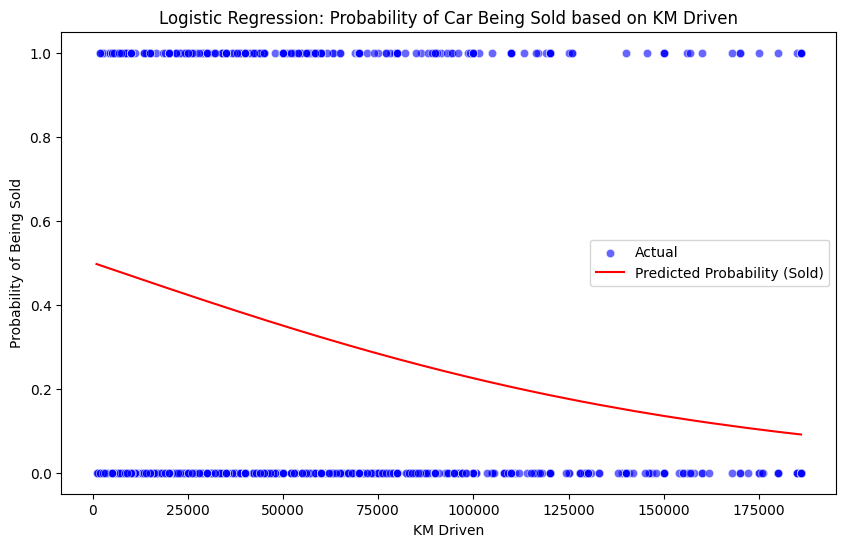

In [14]:
# Correcting the data format issue for prediction
sorted_km_driven_2d = sorted_km_driven.values.reshape(-1, 1)

# Making predictions with the correct data format
sorted_pred_prob_corrected = log_reg_model.predict_proba(sorted_km_driven_2d)[:,1]

# Re-plotting with the corrected data
plt.figure(figsize=(10, 6))

# Scatter plot for actual data
sns.scatterplot(x=X_test['km_driven'], y=y_test, label='Actual', color='blue', alpha=0.6)

# Line plot for predicted probabilities with corrected data
plt.plot(sorted_km_driven, sorted_pred_prob_corrected, label='Predicted Probability (Sold)', color='red')

plt.xlabel('KM Driven')
plt.ylabel('Probability of Being Sold')
plt.title('Logistic Regression: Probability of Car Being Sold based on KM Driven')
plt.legend()
plt.show()

### Log Regression Model Summary:

---
#### Model Coefficients: 
The model's coefficient for KM Driven was approximately -0.00001236, indicating a negative relationship between KM Driven and the probability of a car being sold. This suggests that, as KM Driven increases, the likelihood of a car being sold decreases slightly.

#### Model Predictions:
The plot illustrates that the model predicts a decrease in the probability of being sold with an increase in KM Driven. However, the change is relatively subtle across the range of KM Driven values observed.

#### Model Performance:
The classification report indicated that the model had a precision of 0.73 for predicting cars not sold (label 0) but failed to predict cars that were sold (label 1), with a precision of 0.00 for that class. This indicates that the model was biased towards predicting the majority class (not sold).

The model's recall for the not sold class was 1.00, indicating it correctly identified all not sold instances in the test set, but it had a recall of 0.00 for the sold class, meaning it failed to correctly identify any sold instances.

The overall accuracy of the model on the test data was 0.73, which reflects the imbalance in the dataset and the model's bias towards predicting the majority class.

#### Implications:
The negative coefficient for KM Driven aligns with intuitive expectations that higher mileage may negatively impact a car's attractiveness to buyers. However, the effect size and model performance suggest that KM Driven alone is not a strong predictor of sales outcome.

In summary, the logistic regression model indicates a slightly negative impact of higher mileage on sales probability. However, the model's predictive performance suggests limitations in using KM Driven as the sole predictor and highlights the importance of addressing class imbalance in the dataset for more balanced and accurate predictions.
